In [1]:
import numpy as np

Define a list of words and a list of locations

In [2]:
words = "cat, clothes, table, chair, kitchen, exam, wind, fan, sand, water, toaster, tree, tv screen, speaker, pen, backpack, towel, gym shoes, bicycle, church, car, rug, hat, sunglasses, ball, hammer, cap, laptop, cake, candles, clock, egg, counter top, bottle, plant, guitar, mirror, door, tree, bench, field, cloud, parking lot, fireworks, music, dance floor, kettlebell, jacuzzi, palm tree, sand, kayak, bus, bed, sunglasses, painting, telephone, path, friend, family, co-worker".split(', ')
locations = "beach, hotel, restaurant, office, kitchen, playground, shopping center, school, gym, stadium, spa, nature reserve, art gallery, bank, nightclub".split(', ')

Load a model to generate the similarities between the words and the locations

In [3]:
import gensim.downloader as api
model = api.load("glove-wiki-gigaword-50")


[==================================================] 100.0% 66.0/66.0MB downloaded


Generate a dataframe with the similarities between the words

In [5]:
# remove repeated words
words = list(set(words))
# filter words that are not in the model vocabulary
words = [word for word in words if word in model]

# compute a pandas df containing the similarity bewtween the words in words_sampled
import pandas as pd

df_words_similarities = pd.DataFrame(columns=words, index=words)

for word1 in words:
    for word2 in words:
        df_words_similarities[word1][word2] = model.similarity(word1, word2)

Generate a dataframe with the similarities between the words and the locations

In [13]:
# Do the same between words and locations
locations = list(set(locations))
locations = [location for location in locations if location in model]
locations.append("pharmacy")

df_locations_similarities = pd.DataFrame(columns=locations, index=locations)

for word in locations:
    for location in locations:
        print(word, location)
        df_locations_similarities.loc[word][location] = model.similarity(word, location)


stadium stadium
stadium kitchen
stadium beach
stadium hotel
stadium bank
stadium school
stadium office
stadium gym
stadium playground
stadium spa
stadium nightclub
stadium restaurant
stadium pharmacy
kitchen stadium
kitchen kitchen
kitchen beach
kitchen hotel
kitchen bank
kitchen school
kitchen office
kitchen gym
kitchen playground
kitchen spa
kitchen nightclub
kitchen restaurant
kitchen pharmacy
beach stadium
beach kitchen
beach beach
beach hotel
beach bank
beach school
beach office
beach gym
beach playground
beach spa
beach nightclub
beach restaurant
beach pharmacy
hotel stadium
hotel kitchen
hotel beach
hotel hotel
hotel bank
hotel school
hotel office
hotel gym
hotel playground
hotel spa
hotel nightclub
hotel restaurant
hotel pharmacy
bank stadium
bank kitchen
bank beach
bank hotel
bank bank
bank school
bank office
bank gym
bank playground
bank spa
bank nightclub
bank restaurant
bank pharmacy
school stadium
school kitchen
school beach
school hotel
school bank
school school
school of

In [14]:
# Save both dataframes

# df_words_similarities.to_csv('words_similarities.csv')

df_locations_similarities.to_csv('locations_similarities.csv')

Generate a figure with the similarities between the words

(-0.9843437790340901,
 1.077589604224569,
 -0.8513927477358882,
 1.1759241977486592)

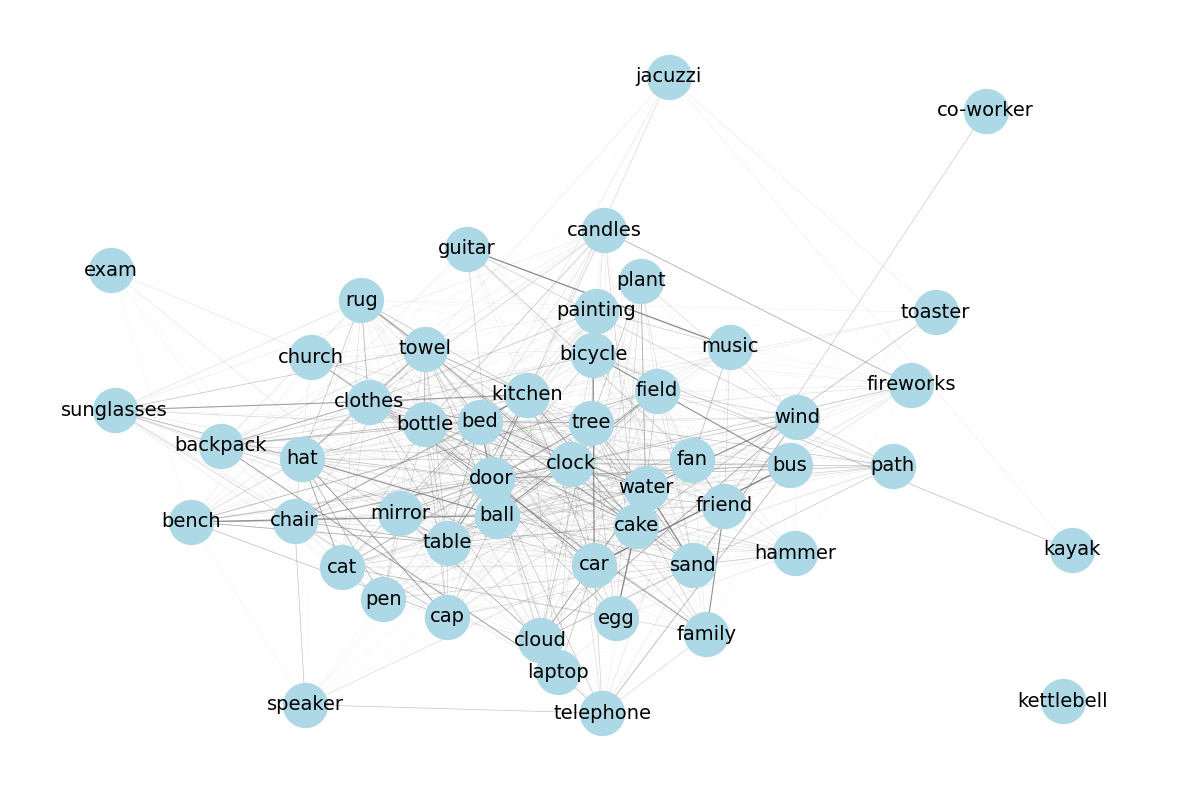

In [7]:
import networkx as nx

# Create a graph with the words as nodes and the similarity as edges
G = nx.Graph()

# Add nodes
G.add_nodes_from(words)

# Add edges from the similarity matrix
for word1 in words:
    for word2 in words:
        if word1 != word2:
            G.add_edge(word1, word2, weight=df_words_similarities.loc[word1][word2])

# remove edges with weight < 0.9
G.remove_edges_from([edge for edge, weight in nx.get_edge_attributes(G, 'weight').items() if weight < 0.3])

# remove autoedges
G.remove_edges_from(nx.selfloop_edges(G))

# Plot the graph
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 10))

pos = nx.spring_layout(G, k=1)
nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='lightblue', ax=ax)
edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]
# scale weights to [0, 1]
weights = [0.1 + 0.9 * (weight - min(weights)) / (max(weights) - min(weights)) for weight in weights]
# Cut weights greater than 1
weights = [weight if weight < 1 else 1 for weight in weights]

nx.draw_networkx_edges(G, pos, edgelist=edges, width=5*weights, edge_color='grey', alpha=weights, ax=ax)

nx.draw_networkx_labels(G, pos, font_size=14, font_family='sans', ax=ax)

# hide the axis
ax.axis('off')

# plt.show()


Create the states of the environment

In [8]:
# For each location, find the 20 most similar words
df_locations = df_locations_similarities.astype(float)
locations_dict = df_locations.apply(lambda x: x.sort_values(ascending=False).head(15)).to_dict()

# remove nan
for location in locations_dict:
    locations_dict[location] = {key: value for key, value in locations_dict[location].items() if not np.isnan(value)}

# Create empty df
df_locations_sampled = pd.DataFrame(columns=['word', 'time', 'location'])

# Create a novel episode id
novel_episode_id = 0

words_to_sample = 10
for i, location in enumerate(locations_dict):
    # Sample 20 words, with the probability of each word being sampled proportional to its value
    p = np.array(list(locations_dict[location].values()))
    p = p / np.sum(p)
    word_i = np.random.choice(list(locations_dict[location].keys()), words_to_sample, p=p)
    time_ = i * words_to_sample + np.arange(words_to_sample)
    location_i = [location] * words_to_sample
    df_locations_i = pd.DataFrame({'word': word_i, 'time': time_, 'location': location_i})
    df_locations_sampled = pd.concat([df_locations_sampled, df_locations_i], ignore_index=True)

In [9]:
df_locations_sampled.to_csv('environment_states.csv')

Order the words alphabetically to plot them in the same order

In [10]:
# Extract the unique words from the sampled df
words_sorted = list(set(df_locations_sampled['word']))
# Order it alphabetically
words_sorted.sort()
# Create a dict with the index of each word
words_sorted = {word: i for i, word in enumerate(words_sorted)}


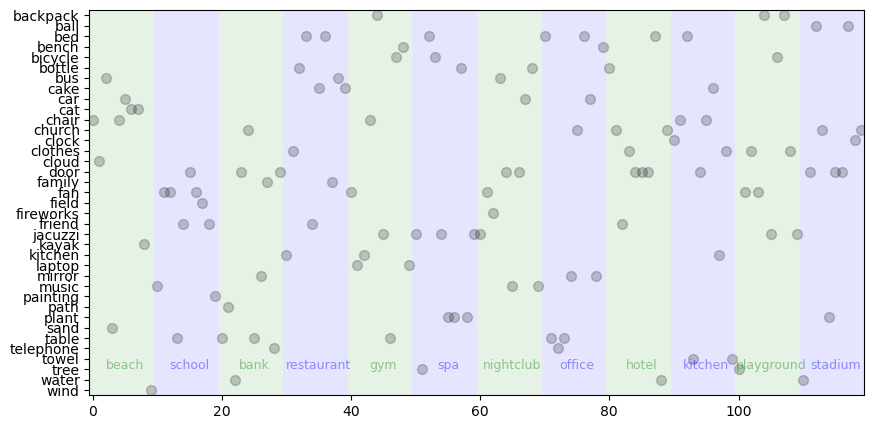

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))

i_prev = 0
colors = ["g", "b"] * (len(locations_dict) // 2 + 1)

from matplotlib.patches import Rectangle

rectangle_height = len(df_locations_sampled["word"].unique())

for c, i in zip(colors, [words_to_sample] * len(locations_dict)):
    rect = Rectangle((i_prev - 0.5, - 0.5), i, rectangle_height + 0.5, linewidth=1, facecolor=c, alpha=0.1)
    ax.add_patch(rect)
    # Plot locations name at the center of the rectangle
    ax.text(i_prev + i / 2, rectangle_height - 3, df_locations_sampled.loc[i_prev]["location"], fontsize=9, ha='center', alpha = 0.4, color=c)

    i_prev += i

# set limits
ax.set_xlim(-0.5, len(df_locations_sampled) - 0.5)
ax.set_ylim(len(df_locations_sampled["word"].unique()) - 0.5, -0.5)

for i, row in df_locations_sampled.iterrows():
    ax.scatter(row['time'], words_sorted[row['word']], color='k', s=50, alpha=0.2)

# Shuffle y axis
ax.set_yticks(np.arange(len(words_sorted.keys())))
# Set words_sampled in reverse order

ax.set_yticklabels(words_sorted.keys())


plt.show()

Define a novel location

In [20]:
novel_location = "pharmacy"

# Get 15 most similar words to the novel location
words_novel = df_locations_sampled["word"].unique()

df_location_novel_similarities = pd.DataFrame(columns=[novel_location], index=words_novel)

for word in words_novel:
    for location in [novel_location]:
        sim = model.similarity(word, location)
        df_location_novel_similarities.loc[word][location] = sim

# Get the 15 most similar words to the novel location
locations_novel_dict = df_location_novel_similarities.apply(lambda x: x.sort_values(ascending=False).head(15)).to_dict()

# remove nan
for location in locations_novel_dict:
    locations_novel_dict[location] = {key: value for key, value in locations_novel_dict[location].items() if not np.isnan(value)}

# sample 10 words
p = np.array(list(locations_novel_dict[novel_location].values()))
p = p / np.sum(p)
word_i = np.random.choice(list(locations_novel_dict[novel_location].keys()), 10, p=p)

df_location_novel_states = pd.DataFrame({'word': word_i, 'time': np.arange(10), 'location': [novel_location] * 10})

In [21]:
df_location_novel_states.to_csv('environment_novel_states.csv')

Tune the similarity matrix to fit to the novel episode semantics